<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# RNN on a Time Series
For these examples we're using data from the Federal Reserve Economic Database (FRED) concerning Sales of Beer, Wine, and Distilled Alcoholic Beverages in millions of dollars from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset
We'll take advantage of pandas' built-in <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> by passing <tt>parse_dates=True</tt>

In [2]:
df = pd.read_csv('../Data/Alchohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

340

In [3]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

340

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.tail()

,S4248SM144NCEN
DATE,
2019-12-01,16197
2020-01-01,10659
2020-02-01,11350
2020-03-01,13410
2020-04-01,12378


In [6]:
df = df.iloc[:-3]

## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

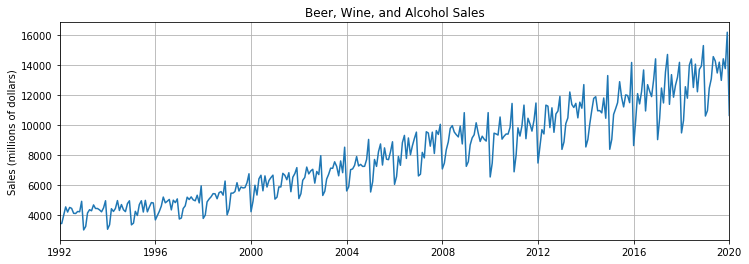

In [7]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [8]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [9]:
test_set

array([10976., 12472., 13098., 14573., 14277., 13484., 14205., 12992.,
       14427., 13773., 16197., 10659.])

It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [11]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [12]:
train_norm.min()

-1.0

In [13]:
train_norm.max()

1.0

In [14]:
train_norm.mean()

-0.21007562609256847

In [15]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [16]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

313

In [17]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9303, -0.9304, -0.8418, -0.7503, -0.8061, -0.7560, -0.7662, -0.8198,
         -0.8216, -0.8000, -0.8030, -0.6897]),
 tensor([-1.]))

## Define the model
This time we'll use an LSTM layer of size (1,100).

In [18]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [19]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [20]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [21]:
epochs = 150

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.26216507
Epoch:  2 Loss: 0.30497852
Epoch:  3 Loss: 0.17262718
Epoch:  4 Loss: 0.19480330
Epoch:  5 Loss: 0.19086072
Epoch:  6 Loss: 0.18267974
Epoch:  7 Loss: 0.18421011
Epoch:  8 Loss: 0.18229756
Epoch:  9 Loss: 0.16082476
Epoch: 10 Loss: 0.15770389
Epoch: 11 Loss: 0.15612866
Epoch: 12 Loss: 0.14924869
Epoch: 13 Loss: 0.14951490
Epoch: 14 Loss: 0.16373222
Epoch: 15 Loss: 0.16589515
Epoch: 16 Loss: 0.16472740
Epoch: 17 Loss: 0.17190520
Epoch: 18 Loss: 0.17004232
Epoch: 19 Loss: 0.17079541
Epoch: 20 Loss: 0.16999656
Epoch: 21 Loss: 0.16635990
Epoch: 22 Loss: 0.16450453
Epoch: 23 Loss: 0.16466707
Epoch: 24 Loss: 0.15625441
Epoch: 25 Loss: 0.15242907
Epoch: 26 Loss: 0.15021059
Epoch: 27 Loss: 0.14157254
Epoch: 28 Loss: 0.13219862
Epoch: 29 Loss: 0.11113893
Epoch: 30 Loss: 0.10326617
Epoch: 31 Loss: 0.07737455
Epoch: 32 Loss: 0.03855282
Epoch: 33 Loss: 0.00333534
Epoch: 34 Loss: 0.08811134
Epoch: 35 Loss: 0.06191740
Epoch: 36 Loss: 0.08497401
Epoch: 37 Loss: 0.03366999
E

## Run predictions and compare to known test set

In [22]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [23]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.2029547542333603,
 0.5343822836875916,
 0.44669774174690247,
 0.8727658987045288,
 0.9349254965782166,
 0.7409918308258057,
 1.0095971822738647,
 0.475128173828125,
 0.9629335403442383,
 0.879854142665863,
 1.3192784786224365,
 0.5002978444099426]

## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [24]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10415.33775886],
       [12449.80564842],
       [11911.55408771],
       [14526.9734692 ],
       [14908.54016075],
       [13718.07835352],
       [15366.91230339],
       [12086.07429504],
       [15080.4675374 ],
       [14570.48465475],
       [17267.89094102],
       [12240.57831791]])

In [25]:
df['S4248SM144NCEN'][-12:]

DATE
2019-02-01    10976
2019-03-01    12472
2019-04-01    13098
2019-05-01    14573
2019-06-01    14277
2019-07-01    13484
2019-08-01    14205
2019-09-01    12992
2019-10-01    14427
2019-11-01    13773
2019-12-01    16197
2020-01-01    10659
Name: S4248SM144NCEN, dtype: int64

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [26]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2020-01-01', '2021-01-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
       '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
      dtype='datetime64[D]')

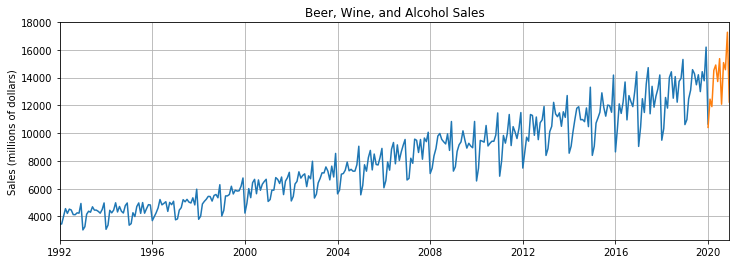

In [27]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

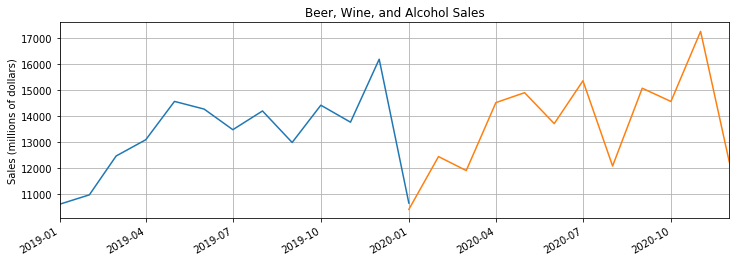

In [28]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2019-01-01':])
plt.plot(x,true_predictions)
plt.show()

For more information on x-axis date formatting in matplotlib, check out <a href='https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.autofmt_xdate'><tt><strong>matplotlib.figure.Figure.autofmt_xdate</strong></tt></a> and <a href='https://matplotlib.org/api/dates_api.html#matplotlib.dates.DateFormatter'><tt><strong>matplotlib.dates.DateFormatter</strong></tt></a>

# Forecast into an unknown future
This time we'll continue training the model using the entire dataset, and predict 12 steps into the future.

In [29]:
epochs = 150

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.03075545
Epoch:  2 Loss: 0.00735304
Epoch:  3 Loss: 0.00146624
Epoch:  4 Loss: 0.00000117
Epoch:  5 Loss: 0.00062939
Epoch:  6 Loss: 0.00000050
Epoch:  7 Loss: 0.00005628
Epoch:  8 Loss: 0.00240123
Epoch:  9 Loss: 0.00035662
Epoch: 10 Loss: 0.00000118
Epoch: 11 Loss: 0.00073790
Epoch: 12 Loss: 0.00026264
Epoch: 13 Loss: 0.00001121
Epoch: 14 Loss: 0.00179362
Epoch: 15 Loss: 0.00170194
Epoch: 16 Loss: 0.00050983
Epoch: 17 Loss: 0.00034065
Epoch: 18 Loss: 0.00209286
Epoch: 19 Loss: 0.00138536
Epoch: 20 Loss: 0.00129617
Epoch: 21 Loss: 0.00073590
Epoch: 22 Loss: 0.00034843
Epoch: 23 Loss: 0.00001600
Epoch: 24 Loss: 0.00000278
Epoch: 25 Loss: 0.00807605
Epoch: 26 Loss: 0.00128275
Epoch: 27 Loss: 0.00036744
Epoch: 28 Loss: 0.00027839
Epoch: 29 Loss: 0.00047251
Epoch: 30 Loss: 0.00030951
Epoch: 31 Loss: 0.00138520
Epoch: 32 Loss: 0.00058414
Epoch: 33 Loss: 0.00000215
Epoch: 34 Loss: 0.00181877
Epoch: 35 Loss: 0.00616549
Epoch: 36 Loss: 0.00206334
Epoch: 37 Loss: 0.00027680
E

## Predict future values, plot the result

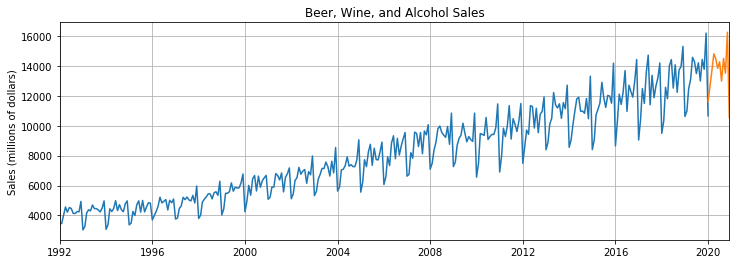

In [30]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# PLOT THE RESULT
# Set a data range for the predicted data.
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2020-01-01', '2021-01-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

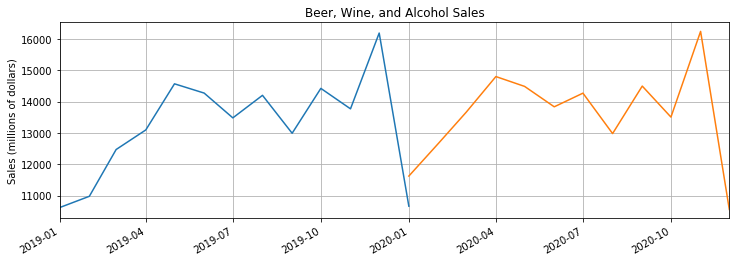

In [31]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2019-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()

## Great job!

<h3>BONUS:</h3>To save time in the future, we've written a function that will take in a time series training data set, and output a tensor of <tt>(seq, label)</tt> tuples.

In [34]:
# Load dependencies
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
"""
This has to be done outside the function definition so that
we can inverse_transform the prediction set later on.
"""
scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract values from the source .csv file
df = pd.read_csv('../Data/Alchohol_Sales.csv',index_col=0,parse_dates=True)
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create the training set of values
train_set = y[:-test_size]

In [35]:
# DEFINE A FUNCTION:
def create_train_data(seq,ws=12):
    """Takes in a training sequence and window size (ws) of
       default size 12, returns a tensor of (seq/label) tuples"""
    seq_norm = scaler.fit_transform(seq.reshape(-1, 1))    
    seq_norm = torch.FloatTensor(seq_norm).view(-1)

    out = []
    L = len(seq_norm)
    for i in range(L-ws):
        window = seq_norm[i:i+ws]
        label = seq_norm[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [36]:
# Apply the function to train_set
train_data = create_train_data(train_set,12)
len(train_data)  # this should equal 313-12

316

In [37]:
train_data[0]

(tensor([-0.9303, -0.9304, -0.8418, -0.7503, -0.8061, -0.7560, -0.7662, -0.8198,
         -0.8216, -0.8000, -0.8030, -0.6897]),
 tensor([-1.]))

In [38]:
help(create_train_data)

Help on function create_train_data in module __main__:

create_train_data(seq, ws=12)
    Takes in a training sequence and window size (ws) of
    default size 12, returns a tensor of (seq/label) tuples

